# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [50]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix 2**17 to 2**15
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 15, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
#   movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['excl_count'] = movie_data['review'].str.count("!!!")

    X_quant_features = movie_data[["excl_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [51]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 32768)
Look at a few rows of the new quantitative features: 
   excl_count  punc_count
0           0          20
1           0          16
2           0          20
3           0           8
4           0           9
5

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [52]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 5320, 'TN': 4658, 'FP': 5365, 'FN': 4657, 'Accuracy': 0.4989, 'Precision': 0.49789424426766493, 'Recall': 0.5332264207677658, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [90]:
from sklearn import linear_model
# alpha 0.0001 to 0.003
svm = linear_model.SGDClassifier(alpha=0.007)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9975, 'TN': 10019, 'FP': 4, 'FN': 2, 'Accuracy': 0.9997, 'Precision': 0.9995991582322878, 'Recall': 0.999799538939561, 'desc': 'svm_train'}


### MODEL: logistic regression

In [71]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [72]:
from sklearn.naive_bayes import MultinomialNB
# alpha value to 3.0 from 1.0
nbs = MultinomialNB(alpha=3.0)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9240, 'TN': 9575, 'FP': 448, 'FN': 737, 'Accuracy': 0.94075, 'Precision': 0.953757225433526, 'Recall': 0.9261300992282249, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [73]:
from sklearn import linear_model
# penalty model to l1 from l2. max_iter 1500 from 1000
prc = linear_model.SGDClassifier(loss='perceptron',penalty='l1',max_iter=1500)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9971, 'TN': 10019, 'FP': 4, 'FN': 6, 'Accuracy': 0.9995, 'Precision': 0.9995989974937344, 'Recall': 0.9993986168186829, 'desc': 'prc_train'}


C:\Users\sepai\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


### MODEL: Ridge Regression Classifier

In [74]:
from sklearn import linear_model
# tolerance 0.001 to 0.01
rdg = linear_model.RidgeClassifier(alpha=8.0,tol=0.01)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier
# depth 4 from 2, estimator 300 from 100
rdf = RandomForestClassifier(max_depth=5, random_state=25,n_estimators=300)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 8720, 'TN': 8231, 'FP': 1792, 'FN': 1257, 'Accuracy': 0.84755, 'Precision': 0.8295281582952816, 'Recall': 0.8740102235140824, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

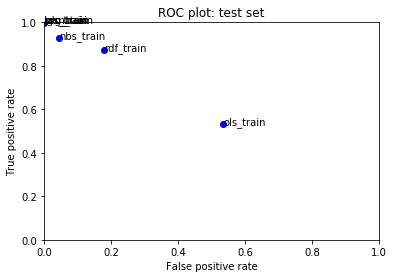

In [59]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [60]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [61]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
9
I have begun to melt so I will make this review as short and sweet as possible.<br /><br />There's this astronaut, and he goes up in a spacecraft with two other guys, ya know? Except something happens that exposes him to radiation, and then when they come back...well, never mind what happened to the other guys, but our astronaut has begun to melt! No, not just burn up, but MELT! Like an ice cream cone in July! Well OK maybe not that fast, but ya know what I mean.<br /><br />Anyway, he gets all red & gooey, and the fact that he's melting makes him really mad. I guess he also checked out the \melting man\" handbook because suddenly he knows that in order to keep from totally melting away, he has to eat human flesh, so he starts ripping people apart.<br /><br />There are other characters, but in a movie where a man melts and melts and melts (and melts), do you really need any others? What's important is WHO will he munch next, and WHAT will be left of them? 

3701
Does anything at all happen in this movie. There are only the bizarre short scenes where I didn't know what the hell was going on so that doesn't count. This movie is sooo boring it hurts, and this is coming from a person who likes it when movies are about making movies. Confused?, well I was after watching this crap. What was Donald Sutherland on, because he missed it with this one completely. And what's with the \pedofile\" scene at the beginning of the movie. Can put anyone to sleep! 4/10"
* * * * * * * * * 
3750
The film was written 10 years back and a different director was planning it with SRK and Aamir in lead roles<br /><br />The film finally was made now with Vipul Shah directing it And Ajay and Salman starring together after a decade HUM DIL DE CHUKE SANAM(1999)<br /><br />The movie however falls short due to it's 90's handling and worst it's loopholes<br /><br />The film tries to pack in too many commercial ingredients and we also hav the love triangle<br /><br />Everyt

6130
Semana Santa is jaw-droppingly bad. It's so wrong in so many ways I don't where to begin. So, let's see...Mira Sorvino, whose judge husband has been shot while protecting her, goes from Madrid to Seville for her cop job. During the holy week (Semana santa, see?...everybody begins to fall sleep..told u it was bad in so many points, even from the beginning), a killer executes his victims like bulls in a bullfighting arena. She teams up with male chauvinist pig Olivier Martinez and nice Feodor Atkine. Soon she discovers she'll be the next target of the killer (who wears a red robe). Why, oh but why?<br /><br />Why..;that's the questionthat has been in my head the whole movie.<br /><br />Q :Why did go to see that A : Because i love Mira Sorvino (i even excuse her for that AT FIRST SIGHT crap)<br /><br />Q : Why were we only 8 people in the theater this saturday on the first week end of release? A : ah-ah-ah. Spider-man got relaesed the same day. But also the fact that the movie has be

7058
Absolute garbage. The reason that this is so terrible is not because it deviated from the formula, but because the plot was just pathetic. <br /><br />The supposed star didn't do anything to solve the case - and neither did anyone else really - it was just routine police work. Utterly tedious.<br /><br />You sat right till the end hoping for a twist - and got nothing but a huge sense of disappointment. <br /><br />There was so much potential in having a relative in apparent kidnap. Could the Lt's personal involvement finally cloud his judgement? <br /><br />All the obvious signs were of a stranger doing it. But surely a genius like Lt C, by constant conversation with the wronged husband, would gradually uncover a fiendish plot involving a tape recorder playing in the shower room while a masked groom surprises the bride, hides the body and then plants subtle clues. It could have been good. It was a complete waste of time.
* * * * * * * * * 
7136
This is just flat out unwatchable. I

9432
Literally every aspect of this science-fiction low-budget flick falls under the categories that have been classified for its predecessors, contemporaries, and those to follow. Bad special effects, a weak storyline, ridiculous amounts of blood and gore, annoying and pointless characters, all that you can expect. \Attack of the Sabretooth\" is about a new vacation resort where the proprietors are genetically engineering Smilodon cats for an attraction. The cats escape and begin to kill people, the guy running the show wants to save them and not warn the unsuspecting visitors about them, and there is a band of visitors and some employees who rebel and plan to kill the cats.<br /><br />Special effects-wise, the film is about an average achievement given its budget. The sabretooths are portrayed through poor CGI. Amazingly, though, the cats look more realistic in an up-close, detailed shot rather than the longer, more distant shots where the CGI is better concealed. Their attacks are r

11298
Unless you are already familiar with the pop stars who star in this film, save yourself the time and stop reading this review after you've reached the end of the next sentence.<br /><br />FORGET YOU EVER STUMBLED UPON THIS FILM AND GO WATCH SOMETHING ELSE.<br /><br />But if you insist on reading, consider: <br /><br />Lame vehicle for Japanese teen idol pretty-boys featuring nonsensical, convoluted \plot\" that drags out for an insufferable amount of time until you're ready to scream.<br /><br />Nothing in this film makes sense. It's an endless series of people expressing various emotions, from joy to anger, from happiness to tragedy, FOR NO GOOD REASON. We can obviously see something incredibly \"dramatic\" is happening, but we just don't GIVE A CRAP WHY 'cause there's no backstory.<br /><br />By the time this film is over, you will be sick and tired of these stupid, lanky, girly stars' faces. You'll be revolted at having spent all this time watching them smile, sneer, cry, look

12905
The thing that stands out in my mind in this film (sadly) is the introduction, where John Berlin (Andy Garcia) is driving into town. You see his Mercedes pass on a winding road through a forest that looks like its loaded with Redwood trees. It's quite beautiful. <br /><br />As to Andy Garcia playing a character with the last name of Berlin, well...Andy is just too hispanic/Latin for it to be passable. Maybe a caucasian father married his Spanish mother for this story? Who knows. But I can tell you that when you put him in a town of farm folks and hicks, he stands out like a sore thumb, especially with his accent that flares up when he gets angry. Yeah, I know, big deal right? He's still a good actor.<br /><br />The title concerns a serial killer who nicknames his victims Jennifer. All of the victims are blind and he dismembers them. The killer has taken a hiatus but suddenly resurfaces when a blind witness (don't ask) appears, Helena Robertson (Uma Thurman). Thurman does a good j

15864
Horrendous pillaging of a classic.<br /><br />It wasn't written convincingly at all why Mary should develop such sympathy for Bates. He may be more stable until they start playing pranks with him, but he still doesn't help himself at all with his actions. (inviting a comparative stranger to stay alone with him in his until recently disused motel; telling the attractive young girl of his past mental issues; lying about the knives, etc... ) This, in addition to her previous knowledge should have kept Mary extremely wary of him, but this somehow doesn't happen just so they can play the 'mistaken-identity-murder-game later on. Which in itself is also ridiculous: 'So-and-so is the real killer - plus her as well - also him! There were too many contrived twists in order to slap a story on screen when the narrative didn't need extending.<br /><br />It was good to see Perkins reprising his famous role again, but that's about the only small pleasure to be had. It's definitely not a patch o

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [76]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1356, 'TN': 1179, 'FP': 1298, 'FN': 1167, 'Accuracy': 0.507, 'Precision': 0.5109269027882442, 'Recall': 0.5374554102259215, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [91]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2122, 'TN': 2042, 'FP': 435, 'FN': 401, 'Accuracy': 0.8328, 'Precision': 0.8298787641767696, 'Recall': 0.8410622275069362, 'desc': 'svm_test'}


### MODEL: logistic regression

In [78]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2135, 'TN': 2053, 'FP': 424, 'FN': 388, 'Accuracy': 0.8376, 'Precision': 0.8343102774521297, 'Recall': 0.8462148236226714, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [79]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1882, 'TN': 1861, 'FP': 616, 'FN': 641, 'Accuracy': 0.7486, 'Precision': 0.7534027221777422, 'Recall': 0.7459373761395165, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [80]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2071, 'TN': 2011, 'FP': 466, 'FN': 452, 'Accuracy': 0.8164, 'Precision': 0.8163184864012614, 'Recall': 0.8208481965913595, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [81]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1860, 'TN': 1788, 'FP': 689, 'FN': 663, 'Accuracy': 0.7296, 'Precision': 0.7296979207532366, 'Recall': 0.737217598097503, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [82]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2158, 'TN': 1991, 'FP': 486, 'FN': 365, 'Accuracy': 0.8298, 'Precision': 0.8161875945537065, 'Recall': 0.8553309552120492, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

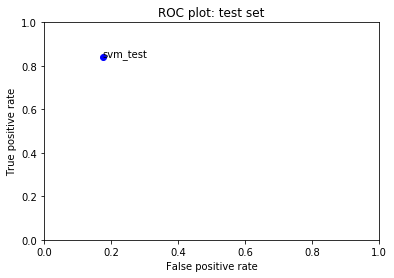

In [93]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits = [svm_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [94]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=25, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 32768)
Look at a few rows of the new quantitative features: 
   excl_count  punc_count
0           0           5
1           0          15
2           0          18
3           0           5
4           0           8
5           0          20
6           0          18
7           0          22
8           0           3
9           0          14
Size 

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [104]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.47408


In [105]:
raw_data.head()

,id,review,punc_count,excl_count
0,12311_10,Naturally in a film who's main themes are of m...,5,0
1,8348_2,This movie is a disaster within a disaster fil...,15,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",18,0
3,7186_2,Afraid of the Dark left me with the impression...,5,0
4,12128_7,A very accurate depiction of small time mob li...,8,0


In [106]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [107]:
my_submission.shape

(25000, 2)

In [108]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation